En este script se utilizará el modelo generado, para realizar las predicciones sobre la clase test, y mostrarlas para verificar su correcto funcionamiento.

Importamos todas las librerías y creamos las rutas que se utilizarán.

In [25]:
import torch
from PIL import Image
from torchvision.transforms import functional as F
import torch.nn.functional as F_nn
from torchvision.utils import draw_bounding_boxes, draw_segmentation_masks

from train import get_model_instance_segmentation

import os
import cv2
import matplotlib.pyplot as plt
import numpy as np

CWD = os.getcwd()
PATH_CITYSCAPE_DATA = os.path.join(CWD, 'datasets/cityscape_data')
PATH_MODEL = os.path.join(CWD, "final_model/maskrcnn_cityscapes.pth")
PATH_IMAGES = os.path.join(CWD, "display_elements/car_segmentation/images")
PATH_VIDEOS = os.path.join(CWD, "display_elements/car_segmentation/videos")
PATH_RESULT_IMAGES = os.path.join(CWD, "results/car_segmentation/images")
PATH_RESULT_VIDEOS = os.path.join(CWD, "results/car_segmentation/videos")

try:
    os.mkdir(PATH_RESULT_IMAGES)
    os.mkdir(PATH_RESULT_VIDEOS)
except FileExistsError:
    pass

print(f"Dataset: {PATH_CITYSCAPE_DATA}")
print(f"Models: {PATH_MODEL}")
print(f"Images: {PATH_IMAGES}")
print(f"Videos: {PATH_VIDEOS}")
print(f"Resulting images: {PATH_RESULT_IMAGES}")
print(f"Resulting videos: {PATH_RESULT_VIDEOS}")

Dataset: c:\Users\gonza\Desktop\universidad\Malaga\Tercero\Vision\Trabajo_Opcional\ADAS-car-distance-prediction\car-distance-prediction\datasets/cityscape_data
Models: c:\Users\gonza\Desktop\universidad\Malaga\Tercero\Vision\Trabajo_Opcional\ADAS-car-distance-prediction\car-distance-prediction\final_model/maskrcnn_cityscapes.pth
Images: c:\Users\gonza\Desktop\universidad\Malaga\Tercero\Vision\Trabajo_Opcional\ADAS-car-distance-prediction\car-distance-prediction\display_elements/car_segmentation/images
Videos: c:\Users\gonza\Desktop\universidad\Malaga\Tercero\Vision\Trabajo_Opcional\ADAS-car-distance-prediction\car-distance-prediction\display_elements/car_segmentation/videos
Resulting images: c:\Users\gonza\Desktop\universidad\Malaga\Tercero\Vision\Trabajo_Opcional\ADAS-car-distance-prediction\car-distance-prediction\results/car_segmentation/images
Resulting videos: c:\Users\gonza\Desktop\universidad\Malaga\Tercero\Vision\Trabajo_Opcional\ADAS-car-distance-prediction\car-distance-predic

# INSTANCIACIÓN DE VEHÍCULOS

## Cargar el modelo

Primero, debemos cargar el modelo entrenado con el fine-tunning, para realizar las predicciones.

In [26]:
# Set the acceleration device (or the CPU if cuda is not available)
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

# Get the model pre-trained model
num_classes = 8
model = get_model_instance_segmentation(8)

# Load the calculated weights in fine-tunning process
data_model = torch.load(PATH_MODEL, map_location=device, weights_only=False)
model.load_state_dict(data_model['model_state_dict'])

# Move the model to the acceleration device and set the model into evaluation mode
model.to(device)
model.eval() 

print("Loaded model and ready to inference.")

Loaded model and ready to inference.


## Predicción en imagen

A continuación, se define una función que, dada una imagen, dibuja sobre ella las máscaras de segmentación y las bounding boxes etiquetadas con la clase que el modelo a asignado a esa instancia

In [27]:
def draw_predictions(image_tensor, pred_masks, pred_boxes, pred_labels, masks_colors=None, custom_labels=False):
    """
        This method draw over a given image the segmentation masks and bounding boxes of given predictions
    Args:
        image_tensor: the image in Tensor format
        pred_masks: The segmentation masks
        pred_boxes: The bounding boxes
        pred_labels: The labels for each predicted class
        masks_colors: The array with the color of each mask
        custom_lables: If True, then the label within the box will be exactly as in pred_labels. 
                       If False, then will be in format "Class: label".


    Returns:
        processed_image: the image with masks and bounding boxes drawn on it
    """

    # DRAW MASKS
    image_int = (image_tensor * 255).to(torch.uint8)

    # if there are no elements detected, returns the original image
    if len(pred_boxes) == 0:
        return image_int.permute(1, 2, 0).cpu().numpy()

    # Get only the vehicles in the masks
    masks_bool = pred_masks > 0.5
    masks_bool = masks_bool.squeeze(1) 

    # Draw the masks
    if len(masks_bool) > 0:
        if masks_colors is not None:
            processed_image = draw_segmentation_masks(image_int, masks_bool, alpha=0.6, colors=masks_colors)
        else:
            processed_image = draw_segmentation_masks(image_int, masks_bool, alpha=0.6, colors="green")
    else:
        processed_image = image_int

    # Draw the bounding boxes
    if len(pred_boxes) > 0:
        if not custom_labels:
            pred_labels = [f"Class: {label}" for label in pred_labels]
        
        processed_image = draw_bounding_boxes(
            processed_image, 
            pred_boxes, 
            labels=pred_labels, 
            colors="yellow", 
            width=3
        )

    processed_image = processed_image.permute(1, 2, 0).cpu().numpy()
    return processed_image

Ahora, se define una función que devuelve las predicciones del modelo, sobre una imagen

In [28]:
def get_predictions(image_tensor, model, score_threshold=0.5):
    """
        This method calculates the predictions of the car segmentation model of a given image,
        and returns the predictions with a confidence level above a given threshold
    Args:
        image: The image to be processed
        model: The model that computes the predictions
        score_threshold: The confidence threshold

    Returns:
        pred_masks: The segmentation masks
        pred_boxes: The bounding boxes
        pred_labels: The labels for each predicted class
    """

    # Turn off gradient mode during the prediction execution
    with torch.no_grad():
        # Get the predictions for that image
        predictions = model([image_tensor])

    prediction = predictions[0]

    # Only keep predictions if the model has a certain level of confidence about them (over 50% score)
    keep_idx = prediction['scores'] > score_threshold

    # If nothing detected, we return the original image
    if not keep_idx.any():
        empty_box = torch.empty((0, 4), device=image_tensor.device)
        empty_mask = torch.empty((0, 1, image_tensor.shape[1], image_tensor.shape[2]), device=image_tensor.device)
        empty_label = torch.empty((0), dtype=torch.int64, device=image_tensor.device)
        return empty_mask, empty_box, empty_label

    pred_boxes = prediction['boxes'][keep_idx]
    pred_masks = prediction['masks'][keep_idx]
    pred_labels = prediction['labels'][keep_idx]

    
    return pred_masks, pred_boxes, pred_labels

Ahora, se va a definir una función que realice el proceso de calcular las predicciones de un modelo de segmentación de vehículos sobre de una imagen, y devuelva la imagen con las predicciones dibujadas sobre ella.

In [29]:
def segmentate_vehicles(image, model, device='cpu'):
    # Convert the image to Tensor format
    image_tensor = F.to_tensor(image).to(device)

    pred_masks, pred_boxes, pred_labels = get_predictions(image_tensor, model, 0.5)
    image_processed = draw_predictions(image_tensor, pred_masks, pred_boxes, pred_labels)

    return image_processed
    

Ahora, se va a mostrar el resultado de procesar una imagen tomada del famoso videojuego GTA V.

Saving image to: c:\Users\gonza\Desktop\universidad\Malaga\Tercero\Vision\Trabajo_Opcional\ADAS-car-distance-prediction\car-distance-prediction\results/car_segmentation/images\gta8_result.png
Image saved correctly


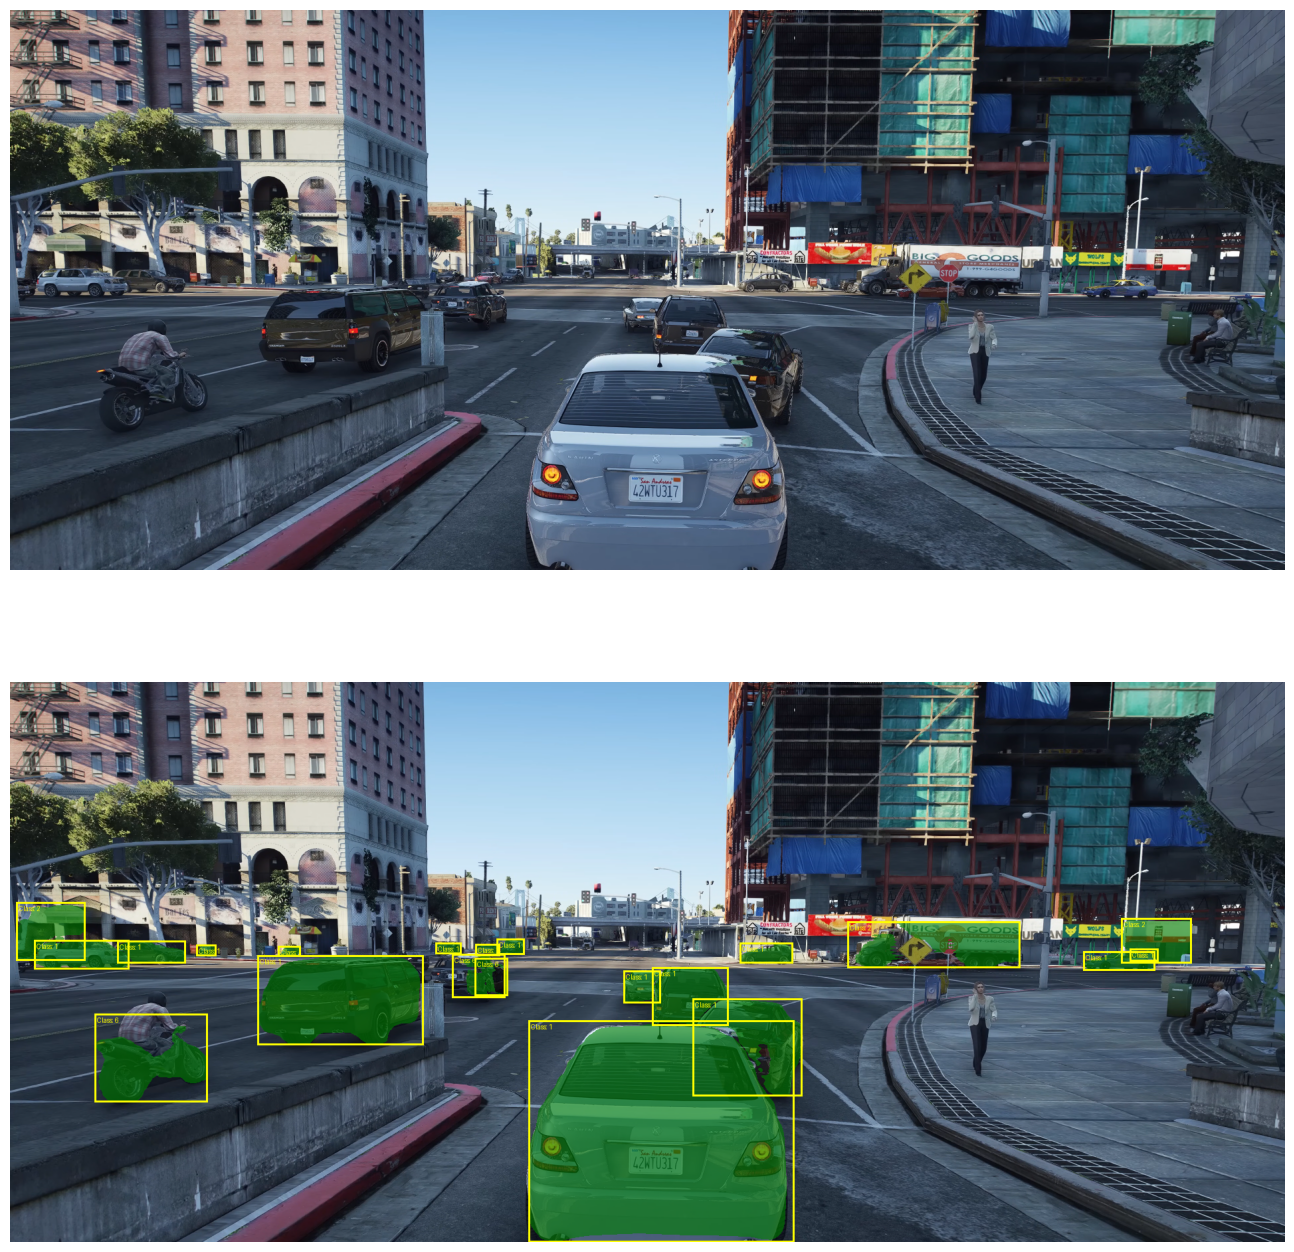

In [30]:
# Get the image
image_name = "gta8.png"
img_path = os.path.join(PATH_IMAGES, image_name)
img_result_path = os.path.join(PATH_RESULT_IMAGES, os.path.splitext(image_name)[0] + '_result.png')

image = cv2.imread(img_path)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

image_processed = segmentate_vehicles(image, model, device)

# Save the processed image in the results directory
output_bgr = cv2.cvtColor(image_processed, cv2.COLOR_RGB2BGR)
print(f"Saving image to: {img_result_path}")
resultado = cv2.imwrite(img_result_path, output_bgr)

if resultado:
    print("Image saved correctly")
else:
    print("An error ocurred while saving the image")

# Show the results
plt.figure(figsize=(24, 16))
plt.subplot(2,1,1)
plt.imshow(image)
plt.axis('off')
plt.subplot(2,1,2)
plt.imshow(image_processed)
plt.axis('off')
plt.show()

# "car":        1, (0, 0, 142)
# "truck":      2, (0, 0, 70)
# "bus":        3, (0, 60, 100)
# "caravan":    4, (0, 0, 90)
# "trailer":    5, (0, 0, 110)
# "motorcycle": 6, (0, 0, 230)
# "bicycle":    7, (119, 11, 32)

Se puede observar que, pese a que comete algunos errores con los objetos a gran distancia. El modelo detecta y clasifica, perfectamente todos los vehículos de la imagen. En especial del entorno cercano, que es el que más preocupa en el problema del cáclulo de la distancia

## Predicción en vídeo

Ya se ha demostrado el funcionamiento del modelo en imágenes. Ahora se procede a calcular las predicciones para una secuencia de vídeo entera.

In [31]:
def process_segmentation_video(video_path, output_path, model, device='cpu', score_threshold=0.5, frames_per_prediction=1):
    """
        This functions processes a video by calculating the model predictions and draw them on the video

    Args:
        video_path: The path to the video file
        output_path: The path where the resulting video is written
        model: The segmentation model that predicts masks and bouding boxes
        device: The device where the computations will be done. CPU by default
        score_threshold: The asurance of the model for shwoing the instance predictions 
        frames_per_prediction: The amount of frames that passes beetwen each prediction. The smaller, the faster the process, but results will be worst. Default is 1 (every frame)

    Returns:
        true if video is correctly processed, False if an error ocurred.
    """
    # Control frames per second
    if frames_per_prediction <= 0:
        print("Frmes per predictions must be > 0\n")
        return False

    cap = cv2.VideoCapture(video_path)

    if not cap.isOpened():
        return False
    else:
        # Create Writer with same properties that the original video
        width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
        height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
        fps = cap.get(cv2.CAP_PROP_FPS)
        fourcc = cv2.VideoWriter_fourcc(*'mp4v') 
        out = cv2.VideoWriter(output_path, fourcc, fps, (width, height))
        
        print(f"Processing video... Resolution: {width}x{height}, FPS: {fps}")
        
        frame_count = 0
        while cap.isOpened():
            ret, frame = cap.read()
            if not ret:
                break # Video ended

            # Convert the image to Tensor format
            frame_tensor = F.to_tensor(frame).to(device)
            
            # Let between model predictions as many frames as the parameter frames_per_prediction
            if frame_count % frames_per_prediction == 0:
                # Process the frame and write it in the ouput route
                pred_masks, pred_boxes, pred_labels = get_predictions(frame_tensor, model, score_threshold)

            frame_processed = draw_predictions(frame_tensor, pred_masks, pred_boxes, pred_labels)
            out.write(frame_processed)
            
            # Show the frame processing in real time
            cv2.imshow("Processed video", frame_processed)
            
            frame_count += 1
            if frame_count % 50 == 0:
                print(f"{frame_count} frames processed...")

            # Exit if press 'q'
            if cv2.waitKey(1) & 0xFF == ord('q'):
                break

        # Liberar recursos
        cap.release()
        out.release()
        cv2.destroyAllWindows()
        return True

Finalmente, se procede a mostrar el resultado de aplicar el procesado, a un video de conducción por Los Ángeles. Se despliega también una ventana donde se puede ver el procesado de cada frame a tiempo real

In [32]:
# Get the video capture
video_name = "video2"
video_path = os.path.join(PATH_VIDEOS, f"{video_name}.mp4")
output_path = os.path.join(PATH_RESULT_VIDEOS,f"{video_name}_result.mp4")

result = process_segmentation_video(video_path, output_path, model, device, score_threshold=0.7, frames_per_prediction=1)

if result:
    print(f"Video saved in: {output_path}")
else:
    print("An error ocurred while openning the video.")

Processing video... Resolution: 1560x720, FPS: 24.001465738365702
Video saved in: c:\Users\gonza\Desktop\universidad\Malaga\Tercero\Vision\Trabajo_Opcional\ADAS-car-distance-prediction\car-distance-prediction\results/car_segmentation/videos\video2_result.mp4


# DISTANCIA CON VEHÍCULOS

En este archivo, se explica e implementa el proceso de calcular las distancias a los vehículos que se encuentran en el mismo carril que nuestro coche.

Empezamos importando las líbrerías y creando los directorios necesarios

In [33]:
import os
import cv2
import matplotlib.pyplot as plt
import numpy as np

import torch
from PIL import Image
from torchvision.transforms import functional as F_torch
import torch.nn.functional as F_nn

from train import get_model_instance_segmentation
from road_lines_sobel import road_line_filter_image, calculate_road_lines, get_road_mask

VEHICLE_CONFIG = {
    1:  1.8,
    2:  2.6,
    3:  2.6,
    4:  2.4,
    5:  2.5,
    6:  0.8,
    7:  0.6
}
FOCAL_LENGTH = 1000

CWD = os.getcwd()
PATH_MODEL = os.path.join(CWD, "final_model/maskrcnn_cityscapes.pth")
PATH_IMAGES = os.path.join(CWD, "display_elements/distance_prediction/images")
PATH_VIDEOS = os.path.join(CWD, "display_elements/distance_prediction/videos")
PATH_RESULT_IMAGES = os.path.join(CWD, "results/distance_prediction/images")
PATH_RESULT_VIDEOS = os.path.join(CWD, "results/distance_prediction/videos")

try:
    os.mkdir(PATH_RESULT_IMAGES)
    os.mkdir(PATH_RESULT_VIDEOS)
except FileExistsError:
    pass

print(f"Images: {PATH_IMAGES}")
print(f"Videos: {PATH_VIDEOS}")
print(f"Resulting images: {PATH_RESULT_IMAGES}")
print(f"Resulting videos: {PATH_RESULT_VIDEOS}")

Images: c:\Users\gonza\Desktop\universidad\Malaga\Tercero\Vision\Trabajo_Opcional\ADAS-car-distance-prediction\car-distance-prediction\display_elements/distance_prediction/images
Videos: c:\Users\gonza\Desktop\universidad\Malaga\Tercero\Vision\Trabajo_Opcional\ADAS-car-distance-prediction\car-distance-prediction\display_elements/distance_prediction/videos
Resulting images: c:\Users\gonza\Desktop\universidad\Malaga\Tercero\Vision\Trabajo_Opcional\ADAS-car-distance-prediction\car-distance-prediction\results/distance_prediction/images
Resulting videos: c:\Users\gonza\Desktop\universidad\Malaga\Tercero\Vision\Trabajo_Opcional\ADAS-car-distance-prediction\car-distance-prediction\results/distance_prediction/videos


## Cargar el modelo

Primero, debemos cargar el modelo entrenado con el fine-tunning, para realizar las predicciones.

In [34]:
# Set the acceleration device (or the CPU if cuda is not available)
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

# Get the model pre-trained model
num_classes = 8
model = get_model_instance_segmentation(8)

# Load the calculated weights in fine-tunning process
data_model = torch.load(PATH_MODEL, map_location=device, weights_only=False)
model.load_state_dict(data_model['model_state_dict'])

# Move the model to the acceleration device and set the model into evaluation mode
model.to(device)
model.eval() 

print("Loaded model and ready to inference.")

Loaded model and ready to inference.


## Obtener los vehículos en el mismo carril

Lo primero que se debe hacer es filtrar aquellos vehículos que no se encuentran en el carril de nuestro vehículo, para quedarse con los vehículos objetivo.

A continuación se implementa una función que comprueba si un vehículo se encuentra en el carril, comprobando si el centro inferior de la máscara del vehículo choca con la máscara del carril.

In [35]:
def is_in_lane(lane_mask, box):
    """ Verify wether the vehicle is over the lane """
    x1, y1, x2, y2 = box
    cx = int((x1 + x2) / 2)
    cy = int(y2) - 10 # 10px arriba del límite inferior para asegurar contacto
    
    if 0 <= cx < lane_mask.shape[1] and 0 <= cy < lane_mask.shape[0]:
        # Si el canal verde de la máscara tiene contenido
        return lane_mask[cy, cx, 1] > 0 
    return False

## Representar distancia

Para poder representar graficamente la distancia, se implementa una función que devuelve un gradiente de color asociado a una distancia: cuanto más cerca más rojo, y cuanto más lejos más verde.

In [36]:
def get_distance_color(dist):
    """ Generate RGB color gradient: Red (near) -> Green (far) """
    if dist < 10: return (0, 0, 255) # Rojo
    if dist > 50: return (0, 255, 0) # Verde
    
    # Interpolación
    ratio = (dist - 10) / 40
    g = int(255 * ratio)
    r = int(255 * (1 - ratio))
    return (r, g, 0)

## Dibujar resultados en imagen

A continuación, se define una función que, dada una imagen, dibuja sobre ella las máscaras de segmentación y las bounding boxes etiquetadas con la clase que el modelo a asignado a esa instancia. Y para los vehículos que se encuentran en el carril, calcula el gradiente de color en base a la distancia, y añade la distancia a la etiqueta.

In [37]:
def draw_predictions_in_lanes(image_tensor, pred_masks, pred_boxes, pred_labels, lane_mask):
    """
        This method draw over a given image the segmentation masks and bounding boxes of given predictions, 
        and for those vehicles on the lane mask, calculate and represents their distance
    Args:
        image_tensor: the image in Tensor format
        pred_masks: The segmentation masks
        pred_boxes: The bounding boxes
        pred_labels: The labels for each predicted class
        lane_mask: The mask for the own lane


    Returns:
        processed_image: the image with masks and bounding boxes drawn on it
    """
    
    # if there are no elements detected, returns the original image
    if len(pred_boxes) == 0:
        return (image_tensor * 255).to(torch.uint8).permute(1, 2, 0).cpu().numpy()

    # Lists with colors and labels for each detected vehicle
    dynamic_colors = []
    dynamic_labels = []
    
    # Asign especific color and distance for vehicles in same lane, and default for the others
    for i in range(len(pred_boxes)):
        box = pred_boxes[i].cpu().numpy().astype(int)
        label_id = pred_labels[i].item()
        
        # If the vehicle is in the same lane
        if is_in_lane(lane_mask, box):
            # Calculate distance
            pixel_w = max(1, box[2] - box[0])
            real_w = VEHICLE_CONFIG[label_id]
            dist = (real_w * FOCAL_LENGTH) / pixel_w
            
            # Get the RGB color
            color = get_distance_color(dist) 
            label = f"Class: {label_id}\nDistance: {dist:.1f}m"
        else:
            # If it is in other lane
            color = (0, 255, 255)           # Cyan
            label = f"Class: {label_id}"

        dynamic_colors.append(color)
        dynamic_labels.append(label)

    # Draw the predictions over the image
    processed_image = draw_predictions(image_tensor, pred_masks, pred_boxes, dynamic_labels, 
                                       masks_colors=dynamic_colors, custom_labels=True)

    return processed_image

Por último se va a implementar una función que dada una imagen, realiza todo el proceso mencionado anteriormente, para devolver la imagen con las distancias calculadas y representadas con los vehículos segmentados.

In [38]:
def predict_distance(image, M, Minv, img_h, img_w, model, 
                     device='cpu', score_threshold=0.5, draw_lane=False):

    filter_image, _ = road_line_filter_image(image)
    no_persp = cv2.warpPerspective(filter_image, M, (img_w, img_h), flags=cv2.INTER_LINEAR)
    left_fit, right_fit, _ = calculate_road_lines(no_persp)

    # Create lane mask
    lane_mask = np.zeros_like(image)

    if left_fit is not None and right_fit is not None:
        # Get the road mask
        lane_mask = get_road_mask(no_persp, left_fit, right_fit, Minv, img_h, img_w)


    # ------------ VEHICLE SEGMENTATION MASKS ------

    # Convert the image to Tensor format
    image_tensor = F_torch.to_tensor(image).to(device)
    masks, boxes, labels = get_predictions(image_tensor, model, score_threshold)


    # ------------ GENERATE RESULTING FRAME --------

    # Draw the lane
    if draw_lane:
        image_processed = cv2.addWeighted(image, 1, lane_mask, 0.3, 0)
        image_processed_tensor = F_torch.to_tensor(image_processed).to(device)

    image_processed = draw_predictions_in_lanes(image_processed_tensor,
                                                masks, boxes, labels, lane_mask)
    
    return image_processed

Se va a mostrar a continuación un ejemplo de este proceso

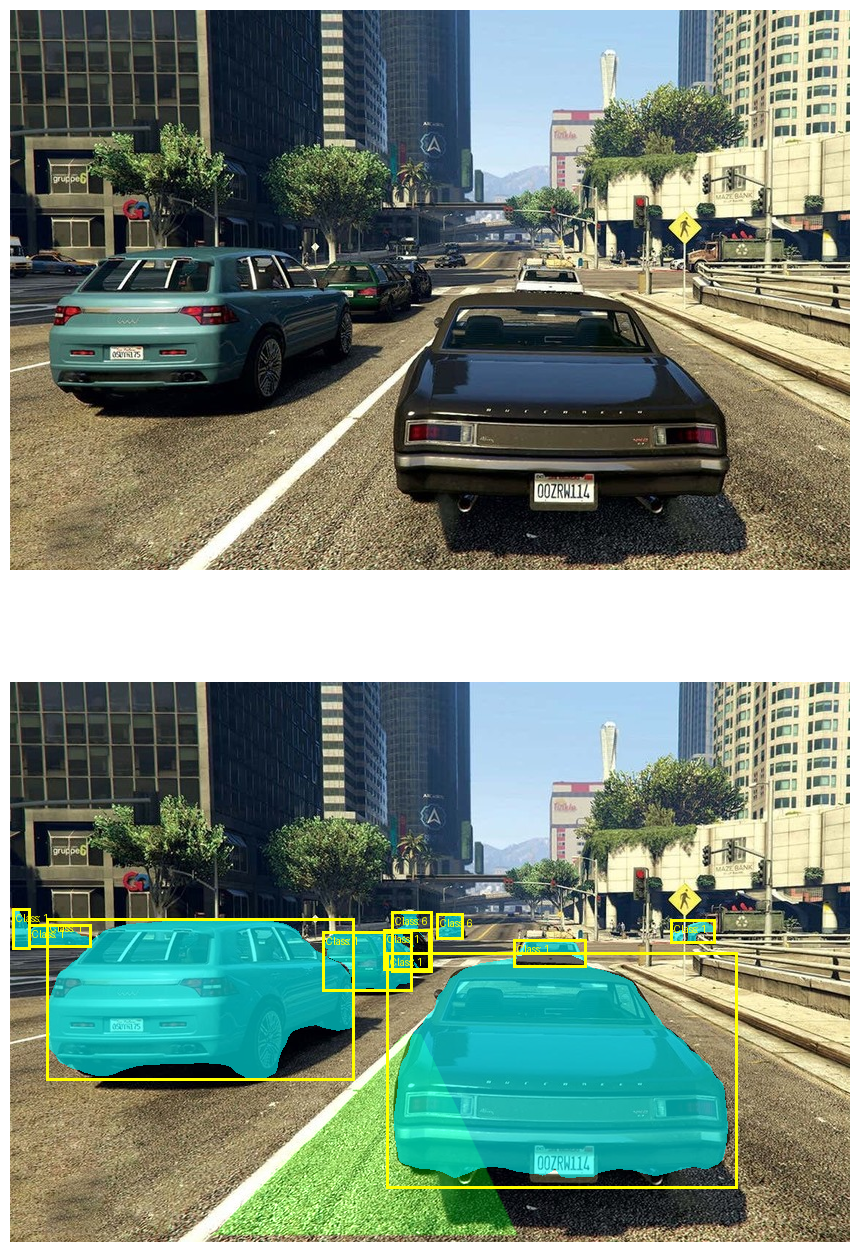

In [39]:
# Get the image
image_name = "gta1.jpeg"
img_path = os.path.join(PATH_IMAGES, image_name)

image = cv2.imread(img_path)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

img_h, img_w = image.shape[:2]

p1_top_left = (int(img_w * 0.45), int(img_h * 0.63)) 
p2_top_right = (int(img_w * 0.52), int(img_h * 0.63)) 
p3_bot_right = (int(img_w * 0.84), int(img_h * 0.99)) 
p4_bot_left  = (int(img_w * 0.28), int(img_h * 0.99)) 

src_pts = np.float32([p1_top_left, p2_top_right, p3_bot_right, p4_bot_left])

dst_pts = np.float32([(int(img_w*0.4), 0), 
                                  (int(img_w*0.6), 0), 
                                  (int(img_w*0.6), img_h), 
                                  (int(img_w*0.4), img_h)
                    ])

M = cv2.getPerspectiveTransform(src_pts, dst_pts)
Minv = np.linalg.inv(M)

image_processed = predict_distance(image, M, Minv, img_h, img_w, model, device, draw_lane=True)

plt.figure(figsize=(24, 16))
plt.subplot(2,1,1)
plt.imshow(image)
plt.axis('off')
plt.subplot(2,1,2)
plt.imshow(image_processed)
plt.axis('off')
plt.show()

## Predicción en vídeo

Se implementa a continuación una función que calcula las predicciones de distancia en una secuencia de vídeo

In [40]:
def process_distance_video(video_path, output_path, model, device='cpu', score_threshold=0.5, 
                           frames_per_prediction=1, src_pts=None, dst_pts=None, focal_lenght=1000, draw_lane=False):
    """
        This function procces a video by predicting the distance of the vechiles in the same lane that the vehicle from which the secuence is recorded.

    Args:
        video_path: The path to the video file
        output_path: The path where the resulting video is written
        model: The segmentation model that predicts masks and bouding boxes
        device: The device where the computations will be done. CPU by default
        score_threshold: The asurance of the model for shwoing the instance predictions 
        frames_per_prediction: The amount of frames that passes beetwen each prediction. The smaller, the faster the process, but results will be worst. Default is 1 (every frame)
        src_pts: The points of a rectangle align with the road lines in the image from the perspective of the car.
        dst_pts: The points of the src_pts rectanggle, but from a "bird eye" perspective.

    Returns:
        true if video is correctly processed, False if an error ocurred.
    """
    # Control frames per second
    if frames_per_prediction <= 0:
        print("Frames per predictions must be > 0\n")
        return False

    cap = cv2.VideoCapture(video_path)

    if not cap.isOpened():
        return False
    else:
        # Create Writer with same properties that the original video
        img_w = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
        img_h = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
        fps = cap.get(cv2.CAP_PROP_FPS) 
        out = cv2.VideoWriter(output_path, cv2.VideoWriter_fourcc(*'mp4v'), fps, (img_w, img_h))
        
        print(f"Processing video... Resolution: {img_w}x{img_h}, FPS: {fps}")

        if src_pts is None:
            p1_top_left = (int(img_w * 0.45), int(img_h * 0.63)) 
            p2_top_right = (int(img_w * 0.52), int(img_h * 0.63)) 
            p3_bot_right = (int(img_w * 0.84), int(img_h * 0.99)) 
            p4_bot_left  = (int(img_w * 0.28), int(img_h * 0.99)) 

            src_pts = np.float32([p1_top_left, p2_top_right, p3_bot_right, p4_bot_left])

        if dst_pts is None:
            dst_pts = np.float32([(int(img_w*0.4), 0), 
                                  (int(img_w*0.6), 0), 
                                  (int(img_w*0.6), img_h), 
                                  (int(img_w*0.4), img_h)
                    ])
            
        # Calculate homography
        M = cv2.getPerspectiveTransform(src_pts, dst_pts)
        Minv = np.linalg.inv(M)
        
        frame_count = 0
        while cap.isOpened():
            ret, frame = cap.read()
            if not ret:
                break # Video ended

            # ------------ LANE MASK ------------------------

            filter_frame, _ = road_line_filter_image(frame)
            no_persp = cv2.warpPerspective(filter_frame, M, (img_w, img_h), flags=cv2.INTER_LINEAR)
            left_fit, right_fit, _ = calculate_road_lines(no_persp)

            # Create lane mask
            lane_mask = np.zeros_like(frame)

            if left_fit is not None and right_fit is not None:
                # Get the road mask
                lane_mask = get_road_mask(no_persp, left_fit, right_fit, Minv, img_h, img_w)


            # ------------ VEHICLE SEGMENTATION MASKS ------

            # Convert the image to Tensor format
            frame_tensor = F_torch.to_tensor(frame).to(device)
            
            # Let between model predictions as many frames as the parameter frames_per_prediction
            if frame_count % frames_per_prediction == 0:
                # Process the frame and write it in the ouput route
                masks, boxes, labels = get_predictions(frame_tensor, model, score_threshold)


            # ------------ GENERATE RESULTING FRAME --------

            # Draw the lane
            if draw_lane:
                frame_processed = cv2.addWeighted(frame, 1, lane_mask, 0.3, 0)
                frame_tensor = F_torch.to_tensor(frame_processed).to(device)

            frame_processed = draw_predictions_in_lanes(frame_tensor,
                                                        masks, 
                                                        boxes, 
                                                        labels, 
                                                        lane_mask)

            out.write(frame_processed)
            
            # Show the frame processing in real time
            cv2.imshow("Processed video", frame_processed)
            
            frame_count += 1
            if frame_count % 50 == 0:
                print(f"{frame_count} frames processed...")

            # Exit if press 'q'
            if cv2.waitKey(1) & 0xFF == ord('q'):
                break

        if frame_count == 0:
            print("Error, no frames have been processed")
            return False

        # Liberar recursos
        cap.release()
        out.release()
        cv2.destroyAllWindows()
        return True

Finalmente, se realiza la predicción de las distancias en un vídeo real.

In [41]:
# Get the video capture
video_name = "video1"
video_path = os.path.join(PATH_VIDEOS, f"{video_name}.mp4")
output_path = os.path.join(PATH_RESULT_VIDEOS,f"{video_name}_result.mp4")

result = process_distance_video(video_path, output_path, model, device)

if result:
    print(f"Video saved in: {output_path}")
else:
    print("An error ocurred while openning the video.")

Processing video... Resolution: 1814x836, FPS: 30.0
50 frames processed...
100 frames processed...
150 frames processed...
200 frames processed...
250 frames processed...
Video saved in: c:\Users\gonza\Desktop\universidad\Malaga\Tercero\Vision\Trabajo_Opcional\ADAS-car-distance-prediction\car-distance-prediction\results/distance_prediction/videos\video1_result.mp4
